# Plan C: Hybrid Optimization with Rocket Payload Growth

## MCM/ICM 2025 - Question 2: Non-Perfect Conditions with Technology Progress

### New Feature: Rocket Payload Growth Model

**Enhancement over PlanC-2-std.ipynb**:
1. Rocket payload capacity grows linearly: $P(t) = P_0 + \Delta P \cdot t$
2. Starting year: 2050 with $P_0 = 125$ tons/launch
3. Annual growth: $\Delta P = 1$ ton/year
4. Time calculation uses cumulative transport with variable capacity

**Decision Variable**: $\alpha \in [0, 1]$
- $\alpha = 0$: Pure Rocket (Plan B)
- $\alpha = 1$: Pure Elevator (Plan A)
- $0 < \alpha < 1$: Hybrid Strategy (Plan C)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")

Libraries imported successfully!


In [17]:
# ==================== Base Parameters (Research-Calibrated - 2025.01) ====================
M = 10**8                 # Total transport volume (tons)

# ==================== Elevator Parameters ====================
# Source: Wikipedia - Space Elevator Economics (Edwards estimate)
E_E_base = 179000 * 3     # Elevator base annual capacity (tons/year)
C_E = 2.2 * 10**5         # Elevator marginal cost (USD/ton) - ~$220/kg
F_E = 1.2 * 10**8        # Elevator fixed cost (USD/year)
p_E = 0.03                # Elevator annual failure probability
sigma_swing = 1.5         # Cable swing parameter (degrees)
theta_limit = 4.0         # Swing angle limit (degrees)
val_rep_E = 5 * 10**9     # Elevator repair cost (USD)

# ==================== Rocket Parameters (WITH GROWTH) ====================
# Source: Wikipedia - Falcon Heavy, SpaceX
P_0 = 125                 # Initial payload in 2050 (tons/launch)
delta_P = 1               # Annual payload growth (tons/year)
f_avg = 1472              # Annual launch frequency (launches/year) - constant
C_R = 1.175 * 10**6       # Rocket marginal cost (USD/ton)
F_R = 5 * 10**7           # Rocket fixed cost (USD/year)
q_R = 0.95                # Rocket launch success probability
val_R = 7.5 * 10**6       # Single launch cost (USD)

# Initial rocket capacity (for comparison)
E_R_initial = f_avg * P_0  # Initial rocket annual capacity

# Effective elevator capacity (considering swing)
ff = 1 - exp(-theta_limit**2 / (2 * sigma_swing**2))
E_E = E_E_base * ff

N = f_avg  # Annual launches

print("=" * 70)
print("Parameter Summary (with Rocket Payload Growth Model)")
print("=" * 70)
print(f"Elevator marginal cost C_E: ${C_E:,.0f}/ton (~$220/kg)")
print(f"Rocket marginal cost C_R: ${C_R:,.0f}/ton (~$1,175/kg)")
print(f"Elevator fixed cost F_E: ${F_E/10**8:.2f} (100M USD/year)")
print(f"Rocket fixed cost F_R: ${F_R/10**7:.1f} (10M USD/year)")
print("-" * 70)
print(f"Elevator effective annual capacity: {E_E:,.0f} tons/year")
print(f"Rocket initial annual capacity (2050): {E_R_initial:,.0f} tons/year")
print(f"Rocket payload growth: +{delta_P} ton/year")
print(f"Total transport volume: {M:,.0f} tons")
print("-" * 70)
print(f"Example payload evolution:")
for year in [2050, 2060, 2080, 2100]:
    t = year - 2050
    P_t = P_0 + delta_P * t
    E_R_t = f_avg * P_t
    print(f"  {year}: P={P_t} tons/launch, E_R={E_R_t:,} tons/year")

Parameter Summary (with Rocket Payload Growth Model)
Elevator marginal cost C_E: $220,000/ton (~$220/kg)
Rocket marginal cost C_R: $1,175,000/ton (~$1,175/kg)
Elevator fixed cost F_E: $1.20 (100M USD/year)
Rocket fixed cost F_R: $5.0 (10M USD/year)
----------------------------------------------------------------------
Elevator effective annual capacity: 521,660 tons/year
Rocket initial annual capacity (2050): 184,000 tons/year
Rocket payload growth: +1 ton/year
Total transport volume: 100,000,000 tons
----------------------------------------------------------------------
Example payload evolution:
  2050: P=125 tons/launch, E_R=184,000 tons/year
  2060: P=135 tons/launch, E_R=198,720 tons/year
  2080: P=155 tons/launch, E_R=228,160 tons/year
  2100: P=175 tons/launch, E_R=257,600 tons/year


In [18]:
# ==================== Rocket Time Calculation with Payload Growth ====================
"""
Key Mathematics:

With growing payload P(t) = P_0 + delta_P * t, the cumulative transport over T years:
  M_R = Sum_{t=0}^{T-1} f_avg * P(t) * q_R
      = f_avg * q_R * Sum_{t=0}^{T-1} (P_0 + delta_P * t)
      = f_avg * q_R * (T * P_0 + delta_P * T*(T-1)/2)

Rearranging:
  M_R = f_avg * q_R * delta_P/2 * T^2 + f_avg * q_R * (P_0 - delta_P/2) * T

Quadratic equation: a*T^2 + b*T + c = 0
  a = f_avg * q_R * delta_P / 2
  b = f_avg * q_R * (P_0 - delta_P / 2)
  c = -M_R

Solution: T = (-b + sqrt(b^2 - 4ac)) / (2a)
"""

def calculate_rocket_time_with_growth(M_R, P_0, delta_P, f_avg, q_R):
    """
    Calculate time needed to transport M_R tons via rockets with growing payload.
    Considers success probability q_R.
    
    Returns: Expected time T (years)
    """
    if M_R <= 0:
        return 0
    
    # Coefficients for quadratic equation
    # Effective annual growth considering success rate
    a = f_avg * q_R * delta_P / 2
    b = f_avg * q_R * (P_0 - delta_P / 2)
    c = -M_R
    
    # Solve quadratic: T = (-b + sqrt(b^2 - 4ac)) / (2a)
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        return float('inf')  # No real solution
    
    T = (-b + np.sqrt(discriminant)) / (2*a)
    return max(0, T)

def calculate_rocket_variance_with_growth(M_R, T_R, P_0, delta_P, f_avg, q_R):
    """
    Approximate variance for rocket transport time with growing payload.
    
    Uses effective average payload over the transport period.
    """
    if M_R <= 0 or T_R <= 0:
        return 0
    
    # Average payload over transport period
    P_avg_eff = P_0 + delta_P * (T_R - 1) / 2
    
    # Variance approximation (similar to fixed payload case)
    Var_T_R = (1 - q_R) * M_R**2 / (N**3 * q_R**3 * P_avg_eff**2)
    return Var_T_R

# Test the function
M_test = 50 * 10**6  # 50 million tons
T_no_growth = M_test / (E_R_initial * q_R)
T_with_growth = calculate_rocket_time_with_growth(M_test, P_0, delta_P, f_avg, q_R)

print("=" * 60)
print("Verification: Rocket Time Calculation")
print("=" * 60)
print(f"Test mass: {M_test/10**6:.0f} million tons")
print(f"Time without growth (fixed P=125): {T_no_growth:.2f} years")
print(f"Time with growth (+1 ton/year): {T_with_growth:.2f} years")
print(f"Time saved: {T_no_growth - T_with_growth:.2f} years ({(T_no_growth - T_with_growth)/T_no_growth*100:.1f}%)")
print(f"\nFinal payload at year {2050+int(T_with_growth)}: {P_0 + delta_P * T_with_growth:.0f} tons/launch")

Verification: Rocket Time Calculation
Test mass: 50 million tons
Time without growth (fixed P=125): 286.04 years
Time with growth (+1 ton/year): 170.48 years
Time saved: 115.57 years (40.4%)

Final payload at year 2220: 295 tons/launch


In [19]:
# ==================== Plan A: Pure Elevator (unchanged) ====================
def plan_A_stats():
    """Calculate pure elevator plan statistics (considering failures)"""
    E_T_A = M / (E_E * (1 - p_E))
    Var_T_A = M * p_E / (E_E * (1 - p_E)**2)
    Std_T_A = sqrt(Var_T_A)
    
    E_C_A = (M * C_E + M * F_E / E_E + M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
    Var_C_A = M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2) / 10**16
    Std_C_A = sqrt(Var_C_A)
    
    return E_T_A, Var_T_A, Std_T_A, E_C_A, Var_C_A, Std_C_A

E_T_A, Var_T_A, Std_T_A, E_C_A, Var_C_A, Std_C_A = plan_A_stats()
print("=" * 55)
print("Plan A (Pure Elevator) - Failure probability p_E =", p_E)
print("=" * 55)
print(f"Time expectation E[T]: {E_T_A:.2f} years")
print(f"Time std dev σ_T: {Std_T_A:.4f} years")
print(f"Time CV: {Std_T_A/E_T_A:.4f}")
print("-" * 55)
print(f"Cost expectation E[C]: {E_C_A:.2f} (100M USD)")
print(f"Cost std dev σ_C: {Std_C_A:.4f} (100M USD)")
print(f"Cost CV: {Std_C_A/E_C_A:.4f}")

Plan A (Pure Elevator) - Failure probability p_E = 0.03
Time expectation E[T]: 197.62 years
Time std dev σ_T: 2.4723 years
Time CV: 0.0125
-------------------------------------------------------
Cost expectation E[C]: 220526.47 (100M USD)
Cost std dev σ_C: 123.6132 (100M USD)
Cost CV: 0.0006


In [20]:
# ==================== Plan B: Pure Rocket (WITH GROWTH) ====================
def plan_B_stats_grow():
    """Calculate pure rocket plan statistics with payload growth"""
    # Time expectation (with growth)
    E_T_B = calculate_rocket_time_with_growth(M, P_0, delta_P, f_avg, q_R)
    Var_T_B = calculate_rocket_variance_with_growth(M, E_T_B, P_0, delta_P, f_avg, q_R)
    Std_T_B = sqrt(Var_T_B)
    
    # Average payload over the mission
    P_avg_eff = P_0 + delta_P * (E_T_B - 1) / 2
    
    # Cost expectation (using effective average payload)
    E_C_B = (M * C_R / q_R + val_R * M * (1 - q_R) / (P_avg_eff * q_R) + 
             M / (N * q_R * P_avg_eff)) / 10**8
    # Variance approximation
    Var_C_B = (C_R**2 * P_avg_eff * M * (1 - q_R) / q_R**2 + 
               val_R**2 * M * (1 - q_R) / (P_avg_eff * q_R**2) + 
               (1 - q_R) * M**2 / (N**3 * q_R**3 * P_avg_eff**2)) / 10**16
    Std_C_B = sqrt(Var_C_B)
    
    return E_T_B, Var_T_B, Std_T_B, E_C_B, Var_C_B, Std_C_B, P_avg_eff

E_T_B, Var_T_B, Std_T_B, E_C_B, Var_C_B, Std_C_B, P_avg_B = plan_B_stats_grow()
print("=" * 65)
print("Plan B (Pure Rocket) - WITH PAYLOAD GROWTH")
print(f"Failure probability 1-q = {1-q_R}, Growth = +{delta_P} ton/year")
print("=" * 65)
print(f"Time expectation E[T]: {E_T_B:.2f} years")
print(f"Time std dev σ_T: {Std_T_B:.4f} years")
print(f"Time CV: {Std_T_B/E_T_B:.4f}")
print("-" * 65)
print(f"Cost expectation E[C]: {E_C_B:.2f} (100M USD)")
print(f"Cost std dev σ_C: {Std_C_B:.4f} (100M USD)")
print(f"Cost CV: {Std_C_B/E_C_B:.4f}")
print("-" * 65)
print(f"Average payload over mission: {P_avg_B:.1f} tons/launch")
print(f"Final year payload: {P_0 + delta_P * E_T_B:.0f} tons/launch")

Plan B (Pure Rocket) - WITH PAYLOAD GROWTH
Failure probability 1-q = 0.050000000000000044, Growth = +1 ton/year
Time expectation E[T]: 273.65 years
Time std dev σ_T: 1.6363 years
Time CV: 0.0060
-----------------------------------------------------------------
Cost expectation E[C]: 1238352.64 (100M USD)
Cost std dev σ_C: 447.2166 (100M USD)
Cost CV: 0.0004
-----------------------------------------------------------------
Average payload over mission: 261.3 tons/launch
Final year payload: 399 tons/launch


In [21]:
# ==================== Plan C: Hybrid Strategy (WITH GROWTH) ====================
def plan_C_stats_grow(alpha):
    """
    Calculate hybrid plan statistics with rocket payload growth.
    
    Key formulas:
    1. Time: Parallel transport, take max of expectations
       E[T_C] = max(E[T_E], E[T_R])
    2. Cost: Independent systems, expectations add linearly
       E[C_C] = Cost_E + Cost_R
    """
    # === Elevator time expectation (considering failures) ===
    if alpha > 0:
        E_T_E = alpha * M / (E_E * (1 - p_E))
        Var_T_E = alpha * M * p_E / (E_E * (1 - p_E)**2)
    else:
        E_T_E = 0
        Var_T_E = 0
    
    # === Rocket time expectation (WITH GROWTH) ===
    if alpha < 1:
        M_R = (1 - alpha) * M
        E_T_R = calculate_rocket_time_with_growth(M_R, P_0, delta_P, f_avg, q_R)
        Var_T_R = calculate_rocket_variance_with_growth(M_R, E_T_R, P_0, delta_P, f_avg, q_R)
    else:
        E_T_R = 0
        Var_T_R = 0
        M_R = 0
    
    # === Total time = max(E[T_E], E[T_R]) (parallel transport) ===
    E_T_C = max(E_T_E, E_T_R)
    if E_T_E >= E_T_R:
        Var_T_C = Var_T_E
    else:
        Var_T_C = Var_T_R
    Std_T_C = sqrt(Var_T_C) if Var_T_C > 0 else 0
    
    # === Elevator cost expectation ===
    if alpha > 0:
        E_C_E = (alpha * M * C_E + 
                 alpha * M * F_E / E_E + 
                 alpha * M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
        Var_C_E = (alpha**2 * M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2)) / 10**16
    else:
        E_C_E = 0
        Var_C_E = 0
    
    # === Rocket cost expectation (WITH GROWTH) ===
    if alpha < 1:
        # Effective average payload over rocket transport period
        P_avg_eff = P_0 + delta_P * (E_T_R - 1) / 2 if E_T_R > 0 else P_0
        
        E_C_R = (M_R * C_R / q_R + 
                 val_R * M_R * (1 - q_R) / (P_avg_eff * q_R) + 
                 M_R / (N * q_R * P_avg_eff)) / 10**8
        # Variance scales with (1-α)²
        Var_C_R = ((1 - alpha)**2 * 
                   (C_R**2 * P_avg_eff * M * (1 - q_R) / q_R**2 + 
                    val_R**2 * M * (1 - q_R) / (P_avg_eff * q_R**2) + 
                    (1 - q_R) * M**2 / (N**3 * q_R**3 * P_avg_eff**2))) / 10**16
    else:
        E_C_R = 0
        Var_C_R = 0
    
    # === Total cost (independent, variances add) ===
    E_C_C = E_C_E + E_C_R
    Var_C_C = Var_C_E + Var_C_R
    Std_C_C = sqrt(Var_C_C) if Var_C_C > 0 else 0
    
    return E_T_C, Var_T_C, Std_T_C, E_C_C, Var_C_C, Std_C_C, E_T_E, E_T_R

# Test
print("Plan C function with growth defined!")
print("\nTest α=0.5:")
E_T, Var_T, Std_T, E_C, Var_C, Std_C, E_T_E, E_T_R = plan_C_stats_grow(0.5)
print(f"Elevator time expectation: {E_T_E:.2f} years")
print(f"Rocket time expectation: {E_T_R:.2f} years")
print(f"Total time expectation (max): {E_T:.2f} years")
print(f"Total cost expectation: {E_C:.2f} (100M USD)")

Plan C function with growth defined!

Test α=0.5:
Elevator time expectation: 98.81 years
Rocket time expectation: 170.48 years
Total time expectation (max): 170.48 years
Total cost expectation: 729625.31 (100M USD)


In [22]:
# ==================== Scan all α values (4 decimal precision) ====================
alphas = np.linspace(0, 1, 10001)  # 10001 points for 4 decimal precision
results_grow = []

for alpha in alphas:
    E_T, Var_T, Std_T, E_C, Var_C, Std_C, E_T_E, E_T_R = plan_C_stats_grow(alpha)
    results_grow.append({
        'alpha': alpha,
        'E_T': E_T,
        'Var_T': Var_T,
        'Std_T': Std_T,
        'E_C': E_C,
        'Var_C': Var_C,
        'Std_C': Std_C,
        'E_T_E': E_T_E,
        'E_T_R': E_T_R
    })

# Convert to numpy arrays
E_T_arr = np.array([r['E_T'] for r in results_grow])
E_C_arr = np.array([r['E_C'] for r in results_grow])
Std_T_arr = np.array([r['Std_T'] for r in results_grow])
Std_C_arr = np.array([r['Std_C'] for r in results_grow])
E_T_E_arr = np.array([r['E_T_E'] for r in results_grow])
E_T_R_arr = np.array([r['E_T_R'] for r in results_grow])

print(f"Calculation complete: {len(alphas)} α values (precision: 0.0001)")
print(f"\nCost expectation range: {E_C_arr.min():.2f} ~ {E_C_arr.max():.2f} (100M USD)")
print(f"Time expectation range: {E_T_arr.min():.2f} ~ {E_T_arr.max():.2f} years")
print(f"Cost std dev range: {Std_C_arr.min():.4f} ~ {Std_C_arr.max():.4f} (100M USD)")
print(f"Time std dev range: {Std_T_arr.min():.4f} ~ {Std_T_arr.max():.4f} years")

Calculation complete: 10001 α values (precision: 0.0001)

Cost expectation range: 220526.47 ~ 1238352.64 (100M USD)
Time expectation range: 129.74 ~ 273.65 years
Cost std dev range: 116.1892 ~ 447.2166 (100M USD)
Time std dev range: 0.7758 ~ 2.4723 years


In [23]:
# ==================== Normalization ====================
def normalize(arr):
    """Min-Max normalization to [0, 1]"""
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max - arr_min < 1e-10:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)

E_T_norm = normalize(E_T_arr)
E_C_norm = normalize(E_C_arr)
Std_T_norm = normalize(Std_T_arr)
Std_C_norm = normalize(Std_C_arr)

print("Normalization complete!")
print(f"\nStandard deviation differences:")
print(f"  Cost σ_C difference: {Std_C_arr.max() - Std_C_arr.min():.4f} (100M USD)")
print(f"  Time σ_T difference: {Std_T_arr.max() - Std_T_arr.min():.4f} years")

Normalization complete!

Standard deviation differences:
  Cost σ_C difference: 331.0274 (100M USD)
  Time σ_T difference: 1.6964 years


In [24]:
# ==================== Decision Function (using Std Dev) ====================
def compute_score_std(w1, w2, w3, w4):
    """
    Composite decision score (using standard deviation)
    
    S = w1 * Ẽ_C + w2 * Ẽ_T + w3 * σ̃_C + w4 * σ̃_T
    
    where Ẽ, σ̃ are normalized values
    """
    return w1 * E_C_norm + w2 * E_T_norm + w3 * Std_C_norm + w4 * Std_T_norm

# Weight scheme comparison
weight_schemes = {
    'Scheme 1: Expectation Only (60:40:0:0)': (0.6, 0.4, 0, 0),
    'Scheme 2: Expectation+StdDev (35:25:25:15)': (0.35, 0.25, 0.25, 0.15),
    'Scheme 3: Risk Averse (30:20:30:20)': (0.30, 0.20, 0.30, 0.20),
    'Scheme 4: Cost Priority (50:15:25:10)': (0.50, 0.15, 0.25, 0.10),
}

print("=" * 75)
print("Optimal α Under Different Weight Schemes (WITH ROCKET PAYLOAD GROWTH)")
print("=" * 75)

optimal_results = {}
for name, (w1, w2, w3, w4) in weight_schemes.items():
    scores = compute_score_std(w1, w2, w3, w4)
    best_idx = np.argmin(scores)
    best_alpha = alphas[best_idx]
    optimal_results[name] = {
        'alpha': best_alpha,
        'score': scores[best_idx],
        'E_T': E_T_arr[best_idx],
        'E_C': E_C_arr[best_idx],
        'Std_T': Std_T_arr[best_idx],
        'Std_C': Std_C_arr[best_idx]
    }
    print(f"\n{name}")
    print(f"  Optimal α = {best_alpha:.4f} ({best_alpha*100:.2f}% Elevator / {(1-best_alpha)*100:.2f}% Rocket)")
    print(f"  Time: {E_T_arr[best_idx]:.2f} years (σ={Std_T_arr[best_idx]:.4f} yr)")
    print(f"  Cost: {E_C_arr[best_idx]:.2f} (100M USD) (σ={Std_C_arr[best_idx]:.4f})")
    print(f"  Composite score: {scores[best_idx]:.4f}")

Optimal α Under Different Weight Schemes (WITH ROCKET PAYLOAD GROWTH)

Scheme 1: Expectation Only (60:40:0:0)
  Optimal α = 1.0000 (100.00% Elevator / 0.00% Rocket)
  Time: 197.62 years (σ=2.4723 yr)
  Cost: 220526.47 (100M USD) (σ=123.6132)
  Composite score: 0.1887

Scheme 2: Expectation+StdDev (35:25:25:15)
  Optimal α = 0.6564 (65.64% Elevator / 34.36% Rocket)
  Time: 129.75 years (σ=0.7758 yr)
  Cost: 570448.73 (100M USD) (σ=153.9618)
  Composite score: 0.1489

Scheme 3: Risk Averse (30:20:30:20)
  Optimal α = 0.6564 (65.64% Elevator / 34.36% Rocket)
  Time: 129.75 years (σ=0.7758 yr)
  Cost: 570448.73 (100M USD) (σ=153.9618)
  Composite score: 0.1374

Scheme 4: Cost Priority (50:15:25:10)
  Optimal α = 1.0000 (100.00% Elevator / 0.00% Rocket)
  Time: 197.62 years (σ=2.4723 yr)
  Cost: 220526.47 (100M USD) (σ=123.6132)
  Composite score: 0.1764


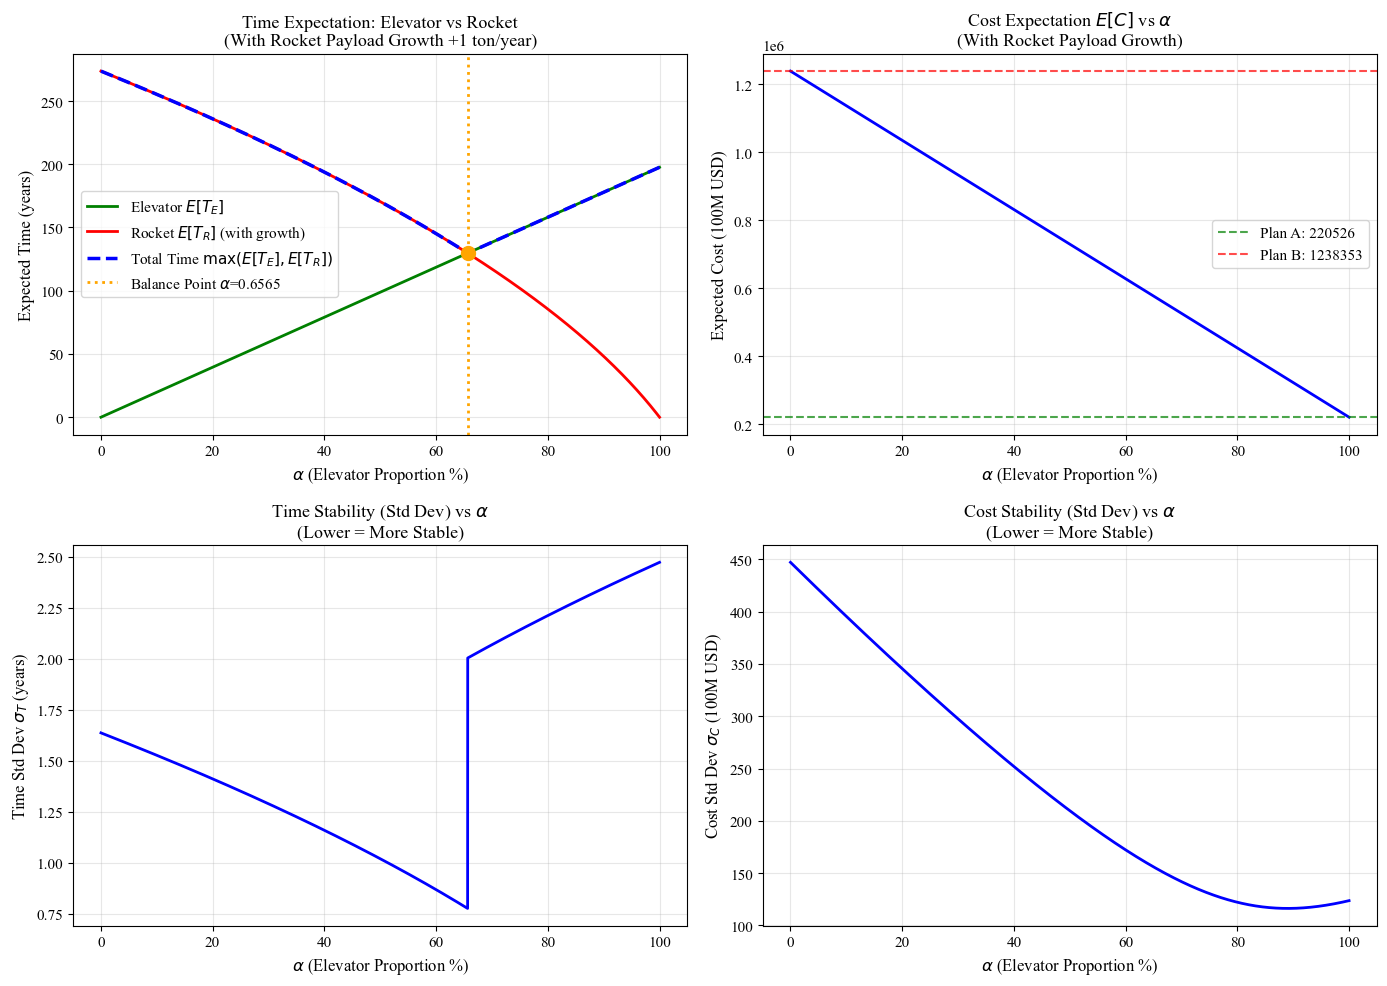

In [25]:
# ==================== Visualization 1: Time Expectation Comparison ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time expectation comparison
ax1 = axes[0, 0]
ax1.plot(alphas * 100, E_T_E_arr, 'g-', linewidth=2, label='Elevator $E[T_E]$')
ax1.plot(alphas * 100, E_T_R_arr, 'r-', linewidth=2, label='Rocket $E[T_R]$ (with growth)')
ax1.plot(alphas * 100, E_T_arr, 'b--', linewidth=2.5, label='Total Time $\\max(E[T_E], E[T_R])$')
# Find crossing point
cross_idx = np.argmin(np.abs(E_T_E_arr - E_T_R_arr))
ax1.axvline(x=alphas[cross_idx]*100, color='orange', linestyle=':', linewidth=2, 
            label=f'Balance Point $\\alpha$={alphas[cross_idx]:.4f}')
ax1.scatter([alphas[cross_idx]*100], [E_T_arr[cross_idx]], color='orange', s=100, zorder=5)
ax1.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax1.set_ylabel('Expected Time (years)', fontsize=12)
ax1.set_title('Time Expectation: Elevator vs Rocket\n(With Rocket Payload Growth +1 ton/year)', fontsize=13)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Cost expectation
ax2 = axes[0, 1]
ax2.plot(alphas * 100, E_C_arr, 'b-', linewidth=2)
ax2.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax2.set_ylabel('Expected Cost (100M USD)', fontsize=12)
ax2.set_title('Cost Expectation $E[C]$ vs $\\alpha$\n(With Rocket Payload Growth)', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=E_C_A, color='g', linestyle='--', alpha=0.7, label=f'Plan A: {E_C_A:.0f}')
ax2.axhline(y=E_C_B, color='r', linestyle='--', alpha=0.7, label=f'Plan B: {E_C_B:.0f}')
ax2.legend()

# Time standard deviation
ax3 = axes[1, 0]
ax3.plot(alphas * 100, Std_T_arr, 'b-', linewidth=2)
ax3.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax3.set_ylabel('Time Std Dev $\\sigma_T$ (years)', fontsize=12)
ax3.set_title('Time Stability (Std Dev) vs $\\alpha$\n(Lower = More Stable)', fontsize=13)
ax3.grid(True, alpha=0.3)

# Cost standard deviation
ax4 = axes[1, 1]
ax4.plot(alphas * 100, Std_C_arr, 'b-', linewidth=2)
ax4.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax4.set_ylabel('Cost Std Dev $\\sigma_C$ (100M USD)', fontsize=12)
ax4.set_title('Cost Stability (Std Dev) vs $\\alpha$\n(Lower = More Stable)', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/planC_std_grow_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

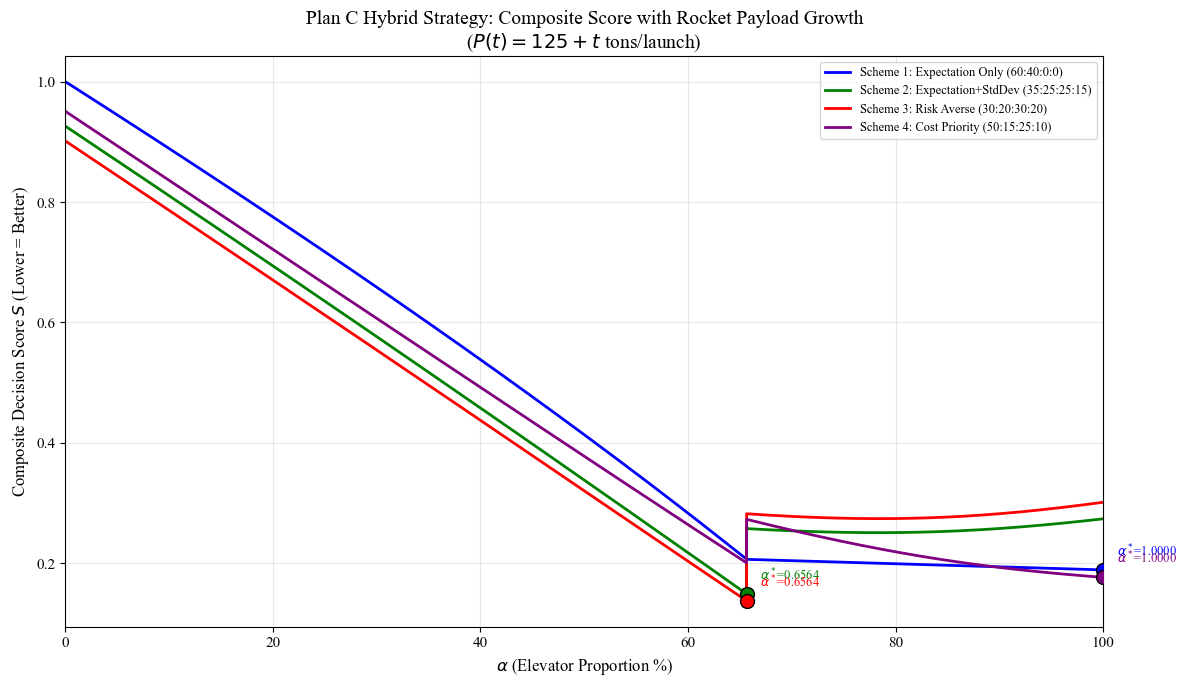

In [26]:
# ==================== Visualization 2: Composite Score Curves ====================
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['blue', 'green', 'red', 'purple']

for i, (name, (w1, w2, w3, w4)) in enumerate(weight_schemes.items()):
    scores = compute_score_std(w1, w2, w3, w4)
    best_idx = np.argmin(scores)
    ax.plot(alphas * 100, scores, '-', color=colors[i], linewidth=2, label=name)
    ax.scatter([alphas[best_idx] * 100], [scores[best_idx]], 
               color=colors[i], s=100, zorder=5, edgecolors='black')
    ax.annotate(f'$\\alpha^*$={alphas[best_idx]:.4f}', 
                (alphas[best_idx] * 100, scores[best_idx]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color=colors[i])

ax.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax.set_ylabel('Composite Decision Score $S$ (Lower = Better)', fontsize=12)
ax.set_title('Plan C Hybrid Strategy: Composite Score with Rocket Payload Growth\n($P(t) = 125 + t$ tons/launch)', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('../results/planC_std_grow_score.png', dpi=300, bbox_inches='tight')
plt.show()

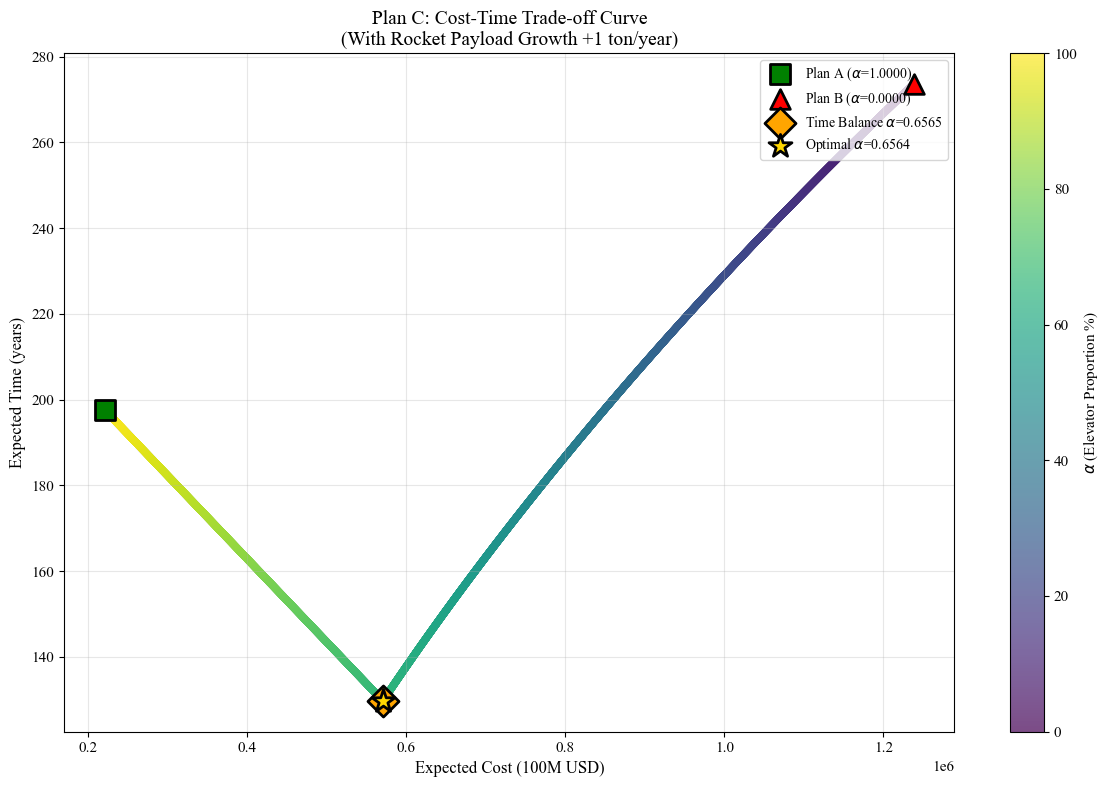

In [27]:
# ==================== Visualization 3: Pareto Frontier ====================
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(E_C_arr, E_T_arr, c=alphas*100, cmap='viridis', s=20, alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('$\\alpha$ (Elevator Proportion %)', fontsize=11)

# Mark key points
ax.scatter([E_C_A], [E_T_A], color='green', s=200, marker='s', 
           edgecolors='black', linewidths=2, label='Plan A ($\\alpha$=1.0000)', zorder=10)
ax.scatter([E_C_B], [E_T_B], color='red', s=200, marker='^', 
           edgecolors='black', linewidths=2, label='Plan B ($\\alpha$=0.0000)', zorder=10)

# Mark balance point
ax.scatter([E_C_arr[cross_idx]], [E_T_arr[cross_idx]], color='orange', s=250, marker='D',
           edgecolors='black', linewidths=2, label=f'Time Balance $\\alpha$={alphas[cross_idx]:.4f}', zorder=10)

# Mark optimal point
best_alpha = optimal_results['Scheme 2: Expectation+StdDev (35:25:25:15)']['alpha']
best_idx = int(best_alpha * 10000)
ax.scatter([E_C_arr[best_idx]], [E_T_arr[best_idx]], color='gold', s=300, marker='*',
           edgecolors='black', linewidths=2, label=f'Optimal $\\alpha$={best_alpha:.4f}', zorder=10)

ax.set_xlabel('Expected Cost (100M USD)', fontsize=12)
ax.set_ylabel('Expected Time (years)', fontsize=12)
ax.set_title('Plan C: Cost-Time Trade-off Curve\n(With Rocket Payload Growth +1 ton/year)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/planC_std_grow_pareto.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# ==================== Comparison: With Growth vs Without Growth ====================
print("=" * 75)
print("COMPARISON: Rocket Payload Growth Effect on Optimal α")
print("=" * 75)

# Read results from original PlanC-2-std (without growth)
# We'll recalculate for comparison
E_R_fixed = f_avg * P_0  # Fixed rocket capacity (no growth)

def plan_C_stats_no_growth(alpha):
    """Original Plan C without growth (for comparison)"""
    if alpha > 0:
        E_T_E = alpha * M / (E_E * (1 - p_E))
        Var_T_E = alpha * M * p_E / (E_E * (1 - p_E)**2)
    else:
        E_T_E = 0
        Var_T_E = 0
    
    if alpha < 1:
        E_T_R = (1 - alpha) * M / P_0 / (N * q_R)
        Var_T_R = (1 - q_R) * ((1 - alpha) * M)**2 / (N**3 * q_R**3 * P_0**2)
    else:
        E_T_R = 0
        Var_T_R = 0
    
    E_T_C = max(E_T_E, E_T_R)
    if E_T_E >= E_T_R:
        Var_T_C = Var_T_E
    else:
        Var_T_C = Var_T_R
    Std_T_C = sqrt(Var_T_C) if Var_T_C > 0 else 0
    
    if alpha > 0:
        E_C_E = (alpha * M * C_E + alpha * M * F_E / E_E + 
                 alpha * M * p_E * val_rep_E / (E_E * (1 - p_E))) / 10**8
        Var_C_E = (alpha**2 * M * p_E * val_rep_E**2 / (E_E * (1 - p_E)**2)) / 10**16
    else:
        E_C_E = 0
        Var_C_E = 0
    
    if alpha < 1:
        M_R = (1 - alpha) * M
        E_C_R = (M_R * C_R / q_R + val_R * M_R * (1 - q_R) / (P_0 * q_R) + 
                 M_R / (N * q_R * P_0)) / 10**8
        Var_C_R = ((1 - alpha)**2 * 
                   (C_R**2 * P_0 * M * (1 - q_R) / q_R**2 + 
                    val_R**2 * M * (1 - q_R) / (P_0 * q_R**2) + 
                    (1 - q_R) * M**2 / (N**3 * q_R**3 * P_0**2))) / 10**16
    else:
        E_C_R = 0
        Var_C_R = 0
    
    E_C_C = E_C_E + E_C_R
    Var_C_C = Var_C_E + Var_C_R
    Std_C_C = sqrt(Var_C_C) if Var_C_C > 0 else 0
    
    return E_T_C, Std_T_C, E_C_C, Std_C_C

# Calculate without growth
results_no_growth = []
for alpha in alphas:
    E_T, Std_T, E_C, Std_C = plan_C_stats_no_growth(alpha)
    results_no_growth.append({'E_T': E_T, 'Std_T': Std_T, 'E_C': E_C, 'Std_C': Std_C})

E_T_ng = np.array([r['E_T'] for r in results_no_growth])
E_C_ng = np.array([r['E_C'] for r in results_no_growth])
Std_T_ng = np.array([r['Std_T'] for r in results_no_growth])
Std_C_ng = np.array([r['Std_C'] for r in results_no_growth])

# Normalize
E_T_ng_norm = normalize(E_T_ng)
E_C_ng_norm = normalize(E_C_ng)
Std_T_ng_norm = normalize(Std_T_ng)
Std_C_ng_norm = normalize(Std_C_ng)

# Find optimal for scheme 2 (without growth)
w1, w2, w3, w4 = 0.35, 0.25, 0.25, 0.15
scores_ng = w1 * E_C_ng_norm + w2 * E_T_ng_norm + w3 * Std_C_ng_norm + w4 * Std_T_ng_norm
best_idx_ng = np.argmin(scores_ng)
alpha_ng = alphas[best_idx_ng]

# Get corresponding value for growth model
best_idx_grow = np.argmin(compute_score_std(w1, w2, w3, w4))
alpha_grow = alphas[best_idx_grow]

print(f"\n{'Parameter':<30} {'No Growth':<20} {'With Growth (+1t/yr)':<20}")
print("-" * 70)
print(f"{'Optimal α*':<30} {alpha_ng:.4f}                {alpha_grow:.4f}")
print(f"{'Elevator %':<30} {alpha_ng*100:.2f}%               {alpha_grow*100:.2f}%")
print(f"{'Rocket %':<30} {(1-alpha_ng)*100:.2f}%               {(1-alpha_grow)*100:.2f}%")
print(f"{'Time (years)':<30} {E_T_ng[best_idx_ng]:.2f}                {E_T_arr[best_idx_grow]:.2f}")
print(f"{'Cost (100M USD)':<30} {E_C_ng[best_idx_ng]:.2f}              {E_C_arr[best_idx_grow]:.2f}")
print("-" * 70)
print(f"\nα Change: {(alpha_grow - alpha_ng)*100:+.2f}%")
print(f"Time Saved: {E_T_ng[best_idx_ng] - E_T_arr[best_idx_grow]:.2f} years")
print(f"Cost Difference: {E_C_arr[best_idx_grow] - E_C_ng[best_idx_ng]:.2f} (100M USD)")

COMPARISON: Rocket Payload Growth Effect on Optimal α

Parameter                      No Growth            With Growth (+1t/yr)
----------------------------------------------------------------------
Optimal α*                     0.7432                0.6564
Elevator %                     74.32%               65.64%
Rocket %                       25.68%               34.36%
Time (years)                   146.91                129.75
Cost (100M USD)                482327.27              570448.73
----------------------------------------------------------------------

α Change: -8.68%
Time Saved: 17.16 years
Cost Difference: 88121.46 (100M USD)


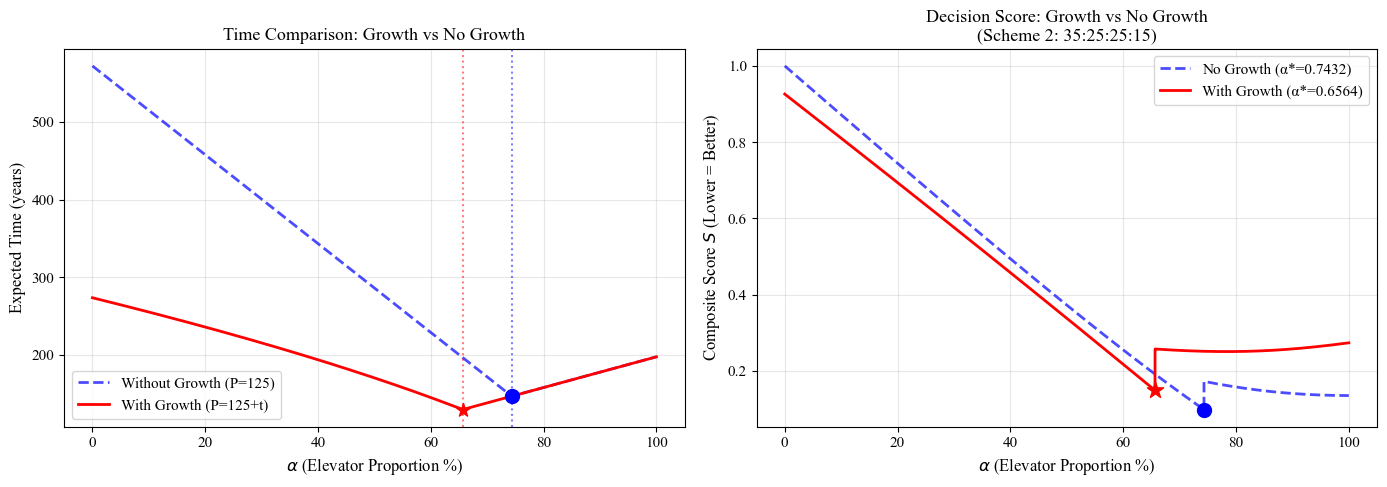

In [29]:
# ==================== Visualization 4: Growth vs No Growth Comparison ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time comparison
ax1 = axes[0]
ax1.plot(alphas * 100, E_T_ng, 'b--', linewidth=2, label='Without Growth (P=125)', alpha=0.7)
ax1.plot(alphas * 100, E_T_arr, 'r-', linewidth=2, label='With Growth (P=125+t)')
ax1.axvline(x=alpha_ng*100, color='blue', linestyle=':', linewidth=1.5, alpha=0.5)
ax1.axvline(x=alpha_grow*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax1.scatter([alpha_ng*100], [E_T_ng[best_idx_ng]], color='blue', s=100, marker='o', zorder=5)
ax1.scatter([alpha_grow*100], [E_T_arr[best_idx_grow]], color='red', s=100, marker='*', zorder=5)
ax1.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax1.set_ylabel('Expected Time (years)', fontsize=12)
ax1.set_title('Time Comparison: Growth vs No Growth', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Score comparison
ax2 = axes[1]
ax2.plot(alphas * 100, scores_ng, 'b--', linewidth=2, label=f'No Growth (α*={alpha_ng:.4f})', alpha=0.7)
scores_grow = compute_score_std(w1, w2, w3, w4)
ax2.plot(alphas * 100, scores_grow, 'r-', linewidth=2, label=f'With Growth (α*={alpha_grow:.4f})')
ax2.scatter([alpha_ng*100], [scores_ng[best_idx_ng]], color='blue', s=100, marker='o', zorder=5)
ax2.scatter([alpha_grow*100], [scores_grow[best_idx_grow]], color='red', s=150, marker='*', zorder=5)
ax2.set_xlabel('$\\alpha$ (Elevator Proportion %)', fontsize=12)
ax2.set_ylabel('Composite Score $S$ (Lower = Better)', fontsize=12)
ax2.set_title('Decision Score: Growth vs No Growth\n(Scheme 2: 35:25:25:15)', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/planC_std_growth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# ==================== Final Conclusion ====================
print("=" * 75)
print("FINAL CONCLUSION: Plan C with Rocket Payload Growth")
print("=" * 75)

rec = optimal_results['Scheme 2: Expectation+StdDev (35:25:25:15)']
alpha_opt = rec['alpha']

print(f"""
【RECOMMENDED OPTIMAL SOLUTION】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Optimal α* = {alpha_opt:.4f}

Resource Allocation:
  • Space Elevator: {alpha_opt * M / 10**6:.2f} million tons ({alpha_opt*100:.2f}%)
  • Rockets: {(1-alpha_opt) * M / 10**6:.2f} million tons ({(1-alpha_opt)*100:.2f}%)

Expected Results (considering failures & payload growth):
  • Total Time: {rec['E_T']:.2f} years (σ={rec['Std_T']:.4f} yr)
  • Total Cost: {rec['E_C']:.2f} (100M USD) (σ={rec['Std_C']:.4f})

Comparison with Pure Strategies:
  Plan A (Pure Elevator): {E_T_A:.2f} yr, {E_C_A:.2f} (100M USD)
  Plan B (Pure Rocket):   {E_T_B:.2f} yr, {E_C_B:.2f} (100M USD)
  Plan C (Hybrid):        {rec['E_T']:.2f} yr, {rec['E_C']:.2f} (100M USD) ✓

Time Balance Point: α = {alphas[cross_idx]:.4f}
  (Elevator and Rocket transport times are equal)

【PAYLOAD GROWTH MODEL】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  P(t) = P₀ + ΔP × t = {P_0} + {delta_P} × t (tons/launch)
  
  2050: 125 tons/launch
  2060: 135 tons/launch (+8%)
  2100: 175 tons/launch (+40%)

【COMPARISON: GROWTH vs NO GROWTH】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Without Growth: α* = {alpha_ng:.4f}
  With Growth:    α* = {alpha_opt:.4f}
  Change:         {(alpha_opt - alpha_ng)*100:+.2f}%
  
  Impact: {'More rockets used' if alpha_opt < alpha_ng else 'More elevators used' if alpha_opt > alpha_ng else 'No change'}
  Reason: Growing rocket capacity makes rocket transport more efficient over time.

【DECISION FUNCTION】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
S(α) = 0.35·Ẽ_C + 0.25·Ẽ_T + 0.25·σ̃_C + 0.15·σ̃_T

where:
  - Ẽ_C, Ẽ_T: Normalized cost and time expectations
  - σ̃_C, σ̃_T: Normalized cost and time standard deviations
  - Stability weight: 40%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("Figures saved to results/ directory:")
print("  1. planC_std_grow_metrics.png - Metrics vs α")
print("  2. planC_std_grow_score.png - Composite score curves")
print("  3. planC_std_grow_pareto.png - Pareto frontier")
print("  4. planC_std_growth_comparison.png - Growth vs No Growth")

FINAL CONCLUSION: Plan C with Rocket Payload Growth

【RECOMMENDED OPTIMAL SOLUTION】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Optimal α* = 0.6564

Resource Allocation:
  • Space Elevator: 65.64 million tons (65.64%)
  • Rockets: 34.36 million tons (34.36%)

Expected Results (considering failures & payload growth):
  • Total Time: 129.75 years (σ=0.7758 yr)
  • Total Cost: 570448.73 (100M USD) (σ=153.9618)

Comparison with Pure Strategies:
  Plan A (Pure Elevator): 197.62 yr, 220526.47 (100M USD)
  Plan B (Pure Rocket):   273.65 yr, 1238352.64 (100M USD)
  Plan C (Hybrid):        129.75 yr, 570448.73 (100M USD) ✓

Time Balance Point: α = 0.6565
  (Elevator and Rocket transport times are equal)

【PAYLOAD GROWTH MODEL】
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  P(t) = P₀ + ΔP × t = 125 + 1 × t (tons/launch)
  
  2050: 125 tons/launch
  2060: 135 tons/launch (+8%)
  2100: 175 tons/launch (+40%)

【COMPARISON: GROWTH vs NO GROW